<a href="https://colab.research.google.com/github/MagicConch9863/MATLAB_Aufgaben/blob/main/tabular_rl_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Local Setup

If you prefer to work locally, see the following instructions for setting up Python in a virtual environment.
You can then ignore the instructions in "Colab Setup".

If you haven't yet, create a [conda](https://docs.conda.io/projects/conda/en/latest/user-guide/install/index.html) environment using:
```
conda create --name rl_exercises
conda activate rl_exercises
```
The remaining dependencies can be installed with pip:
```
pip install matplotlib pillow numpy ipykernel "gymnasium[toy-text]"
```

Even if you are running the Jupyter notebook locally, please run the code cell in **Colab Setup**, because it defines some global variables required later.

## Colab Setup

Google Colab provides you with a temporary environment for python programming.
While this conveniently works on any platform and internally handles dependency issues and such, it also requires you to set up the environment from scratch every time.
The "Colab Setup" section below will be part of **every** exercise and contains utility that is needed before getting started.

There is a timeout of about ~12 hours with Colab while it is active (and less if you close your browser window).
Any changes you make to the Jupyter notebook itself should be saved to your Google Drive.
We also save all recordings and logs in it by default so that you won't lose your work in the event of an instance timeout.
However, you will need to re-mount your Google Drive and re-install packages with every new instance.

In [ ]:
"""Your work will be stored in a folder called `rl_ws23` by default to prevent Colab
instance timeouts from deleting your edits.
We do this by mounting your google drive on the virtual machine created in this colab
session. For this, you will likely need to sign in to your Google account and allow
access to your Google Drive files.
"""

from pathlib import Path
try:
    from google.colab import drive
    drive.mount("/content/gdrive")
    COLAB = True
except ImportError:
    COLAB = False

# Create paths in your google drive
if COLAB:
    DATA_ROOT = Path("/content/gdrive/My Drive/rl_ws24")
    DATA_ROOT.mkdir(exist_ok=True)
else:
    DATA_ROOT = Path.cwd() / "rl_ws24"

# Install **python** packages
if COLAB:
    %pip install matplotlib pillow numpy "gymnasium[toy-text]"

Mounted at /content/gdrive


# Exercise 1: Tabular Reinforcement Learning

In this homework, we will implement basic planning and reinforcement learning algorithms.
We will look at Policy Iteration and Value Iteration, as well as tabular Q-Learning.
The algorithms will be evaluated on a gridworld task from OpenAI gym.

All homeworks are self-contained.
They can be completed in their respective notebooks.
Please fill in any missing code or answer any questions that are marked with `##TODO##` statements.
Questions not marked with `##TODO##` are self-test questions and do **not** need to be answered for points.
To edit and re-run code, you can simply edit and restart the code cells below.
When you are finished, you will need to submit the notebook as well as all saved figures (see exercises) as a zip file via Ilias.

We start by importing all the necessary python modules and defining some helper functions which you do not need to change.
Still, make sure you are aware of what they do.

In [ ]:
%matplotlib inline

import time

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


SEED = 1

# specify the path to save the recordings of this run to.
DATA_PATH = DATA_ROOT / "exercise_1" / time.strftime("%Y-%m-%d_%H-%M")

def save_figure(fig: plt.Figure, save_name: str) -> None:
    """Saves a figure into your google drive folder or local directory"""
    DATA_PATH.mkdir(parents=True, exist_ok=True)
    path = DATA_PATH / (save_name + ".png")
    fig.savefig(str(path))

In [ ]:
import gymnasium as gym  # gymnasium is successor to gym
from gymnasium.envs.toy_text.frozen_lake import FrozenLakeEnv


def measure_policy_success(
    env: FrozenLakeEnv,
    pi: np.ndarray,
    n_eval: int,
    render: bool = False,
    fps: float | None = None,
) -> float:
    """Evaluate a policy on an environment and return success rate

    :param env: FrozenLake env
    :param pi: a policy that dictates the deterministic action to take in each state [n_states]
    :param render: render the trajectory?
    :return: The mean success rate of the given policy
    """

    successes = []
    for _ in range(n_eval):
        state, info = env.reset()
        if render:
            display.clear_output(wait=True)
            display.display(Image.fromarray(env.render()))
            if fps is not None:
                time.sleep(1 / fps)
        for _ in range(100):
            action = int(pi[state])

            state, reward, terminated, truncated, info = env.step(action)

            if render:
                display.clear_output(wait=True)
                display.display(Image.fromarray(env.render()))
                if fps is not None:
                    time.sleep(1 / fps)

            if terminated or truncated:
                successes.append(reward)
                break

    return np.mean(successes)


## The FrozenLake Environment
First, let's have a look at the problem we are solving. The agent controls the movement of a character in a grid world.
Some tiles of the grid are walkable, and others lead to the agent falling into the water.
Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction.
The agent is rewarded for finding a walkable path to a goal tile.
The episode ends when you reach the goal or fall in a hole.
You receive a reward of 1 if you reach the goal, and zero otherwise.
Actions are encoded as integers 0 = left, 1 = down, 2 = right and 3 = up.
The states are counted from 0 to $N_{states}$.

![The FrozenLake Environment](https://gymnasium.farama.org/_images/frozen_lake.gif)

See https://gymnasium.farama.org/environments/toy_text/frozen_lake/

### Hint
Like all DiscreteEnvs in Gym, FrozenLake has a property `P` which is a dictionary of lists, where
```
P[s][a] == [(transition probability, next state, reward, done), ...]
```
for a state $s$ and an action $a$.
In FrozenLake, the player will move in intended direction with probability of $1/3$ else will move in either perpendicular direction with equal probability of $1/3$ in both directions.
In non-terminal states, `len(P[s][a]) == 3`.
This environment is very similar to the one shown in the Optimal Decision Making lecture.

Execute the next cell to see what a randomly initialized policy does.

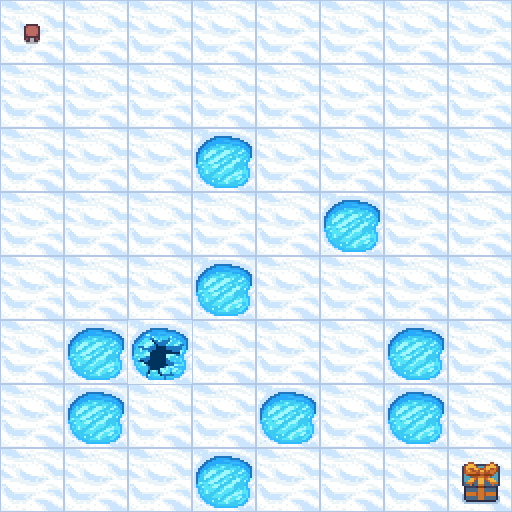

Random policy success rate=0.0


In [ ]:
env: FrozenLakeEnv = gym.make("FrozenLake-v1", map_name="8x8", render_mode="rgb_array")
env.reset(seed=SEED)

n_actions = env.action_space.n
n_states = env.observation_space.n
pi_random = np.random.default_rng(SEED).integers(n_actions, size=(n_states,))

success_rate = measure_policy_success(env, pi_random, n_eval=3, render=True, fps=30 if not COLAB else None)

print(f"Random policy success rate={success_rate}")

## **TASK 1: Policy Iteration**
The first algorithm we will implement is called Policy Iteration.
It consists of an inner and an outer loop.
The inner loop is called Policy Evaluation and computes state values for the _current policy_.
For every state, it averages the expected returns of all possible actions in that state, weighted by the current policy's action probabilities.
The outer loop is called Policy Improvement and it uses the current policy's value function to return an improved policy.
It does this by choosing an action for each state that maximizes the expected value of the next state.
In Policy Iteration, we first initialize a policy and value function randomly, and then iteratively run Policy Evaluation and Policy Improvement until convergence.

The **pseudocode** looks as follows:

---
- **Initialize** $V_{(0)}^{\pi_0}(s)$ randomly for all $s$, $\pi_0 \leftarrow$ uniform, $k = 0$

- **Repeat** for $i=1, 2, \dots$

    - **Policy Evaluation:**

        - **Initialize** $V_{(0)}^{\pi_{i}}(s) \leftarrow V_{(k)}^{\pi_{i-1}}(s)$ (i.e. initialize the value function of the new policy with the converged value function of the old policy)

        - **Repeat** for $k=1, 2, \dots$

            \begin{equation*}
                V_{(k)}^{\pi_{i}}(s) \leftarrow \sum_a \pi(a \mid s) \sum_{s'} P(s' \mid s,a) \Big( r(s,a,s') + \overline{d} \gamma \, V_{(k - 1)}^{\pi_{i}}(s') \Big)
            \end{equation*}

        - **Until convergence**

    - **Policy Improvement:**

        \begin{align*}
            \pi_{i}(a \mid s) \leftarrow \begin{cases}
                1, & \text{if } a = \underset{a'}{\arg \max} \sum_{s'} P(s' \mid s,a') \Big( r(s,a',s') + \overline{d} \gamma \, V^{\pi_i}(s') \Big)\\
                0 & \text{else}
            \end{cases}
        \end{align*}

- **Until convergence**
---

Because the reward depends on the next state and not just the action (i.e. $r=r(s,a,s')$), we must slightly update the equations for policy iteration and value iteration seen in the lecture.

Also note the addition of $\overline{d}$ to the formulas from the lecture.
The expected value of some transition is the transition reward plus the (discounted) value of the next state.
However, some transitions result in termination (e.g. falling through the ice).
For these transitions, the trajectory is over and we cannot use the (discounted) value of the next state.

### Task 1.1 (4 Points)

In this first task you have to implement the core algorithm of **policy evaluation** (2 points) and **policy improvement** (2 points), both marked by `##TODO##`.
For convenience in this discrete environment, we maintain both an array called `pi_prob` for the _action probabilities_ and an array called `pi` that just contains the deterministic action that the policy takes in each state.

After you have finished implementing the corresponding functions, execute the code cell.
Your algorithm should be able to solve the task with around ~65% success rate.

Note: the dynamics of the environment are available to you through the `mdp` variable.
If you index this with the state and the action (i.e. `mdp[state][action]`), you are given a list of possible transitions, where each transition is a tuple of the form `(transition_prob: float, next_state: int, reward: float, done: bool)`.
In other words, each transition has an associated probability, reward, and next state.

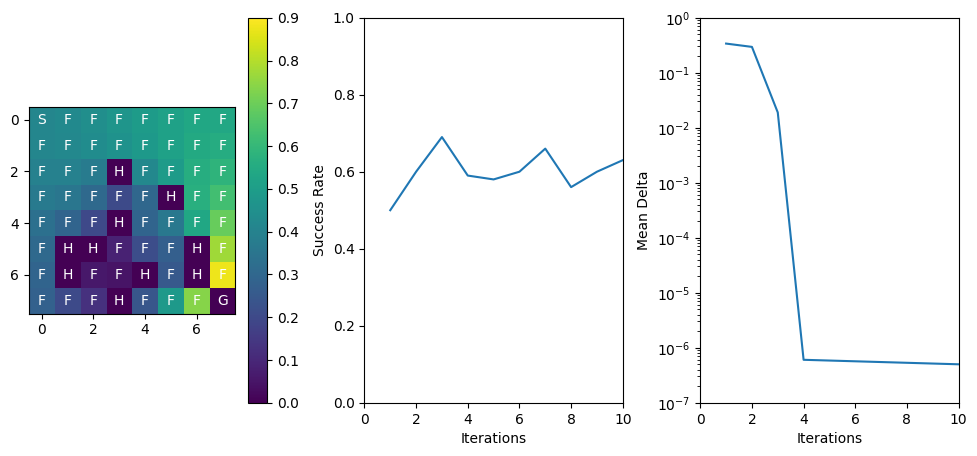

In [ ]:
def policy_evaluation(
    mdp: dict[int, dict[int, list[tuple[float, int, float, bool]]]],
    pi_prob: np.ndarray,
    previous_value: np.ndarray,
    gamma: float,
    max_iters: int = 10000,
) -> np.ndarray:
    """Perform the Policy Evaluation step given a policy pi and an environment.

    :param mdp: an MDP as a list of transitions for each state-action pair
    :param pi_prob: Action probabilities [num_states, num_actions]
    :param previous_value: Initial value function [num_states]
    :return: value function of the provided policy [num_states]
    """



    n_states, n_actions = pi_prob.shape
    for _ in range(max_iters):
        value = np.zeros_like(previous_value)
        ## TODO ##
        for state in range(n_states):
            # loop over all actions the policy can take
            for action, action_prob in enumerate(pi_prob[state]):
                transitions = mdp[state][action]
                q_s_a = sum(
                    transition_prob
                    * (reward + (not done) * gamma * previous_value[next_state])
                    for transition_prob, next_state, reward, done in transitions
                )

                value[state] += action_prob * q_s_a
        ## END ##

        # run policy evaluation until convergence
        if np.allclose(value, previous_value):
            break

        # save current value estimate for next iteration
        previous_value = np.copy(value)

    return value

def policy_improvement(
    mdp: dict[int, dict[int, list[tuple[float, int, float, bool]]]],
    value: np.ndarray,
    gamma: float,
) -> tuple[np.ndarray, np.ndarray]:
    """Perform the Policy Improvement step given a value function.

    :param mdp: an MDP as a list of transitions for each state-action pair
    :param value: Value function of a policy [num_states]
    :return: New policy [num_states] and distribution over action probabilities [num_states, num_actions]
    """
    n_states, n_actions = len(mdp), len(mdp[0])
    # initialize policy
    # contains the actual actions
    pi = np.zeros(shape=n_states, dtype=np.int64)
    # contains the action probabilities for each state
    pi_prob = np.zeros(shape=(n_states, n_actions))

    ## TODO ##
    for state in range(n_states):
        # list of q values for current state s
        qs = []
        for action in range(n_actions):
            transitions = mdp[state][action]
            q_s_a = sum(
                transition_prob * (reward + (not done) * gamma * value[next_state])
                for transition_prob, next_state, reward, done in transitions
            )
            qs.append(q_s_a)

        # new policy action is the one with highest q
        pi[state] = np.argmax(qs)
        # set probability of best action to 1.0, all others 0.0
        pi_prob[state, pi[state]] = 1
    ## END ##

    return pi, pi_prob

def policy_iteration(
    env: FrozenLakeEnv,
    gamma: float,
    n_iters: int,
    max_iters_policy_eval: int = 10000,
    random_init: bool = True,
) -> plt.Figure:
    """Policy Iteration algorithm

    :param env: a FrozenLakeEnv environment
    :param gamma: discount factor
    :param n_iter: number of loop iterations
    :param max_iters_policy_eval: maximum iterations of policy evaluation for each loop iteration
    :param random_init: initialize value function randomly or as all zeros?
    :return: Figure containing final value function and learning curves
    """

    n_states = env.observation_space.n
    n_actions = env.action_space.n
    mdp = env.unwrapped.P
    rng = np.random.default_rng(seed=SEED)
    if random_init:
        value = rng.normal(loc=0, scale=0.5, size=(n_states,))
    else:
        value = np.zeros(shape=n_states)
    pi_prob = (
        np.ones(shape=(n_states, n_actions)) / n_actions
    )  # contains the action probabilities for each state
    pi = np.zeros(shape=n_states, dtype=np.int64)  # contains the actual actions

    # setup plotting
    fig, (ax_value, ax_success, ax_change) = plt.subplots(1, 3, figsize=(12,5))
    fig.subplots_adjust(wspace=0.3)
    grid = (nrow, ncol) = (env.unwrapped.nrow, env.unwrapped.ncol)
    image_value = ax_value.imshow(value.reshape(grid), vmin=0.0, vmax=0.9)
    fig.colorbar(image_value)
    for i in range(nrow):
        for j in range(ncol):
            desc = env.unwrapped.desc[i, j].decode()
            ax_value.text(j, i, desc, ha="center", va="center", color="w")
    ax_success.set(xlabel="Iterations", ylabel="Success Rate")
    ax_success.set_xlim(0, n_iters)
    ax_success.set_ylim(0.0, 1.0)
    line_success, *_ = ax_success.plot([], [])
    ax_change.set(xlabel="Iterations", ylabel="Mean Delta")
    ax_change.set_xlim(0, n_iters)
    ax_change.set_ylim(1e-7, 1.0)
    ax_change.set_yscale("log")
    line_change, *_ = ax_change.plot([], [])

    env.reset(seed=int(rng.integers(2**32)))

    success_rates = []
    mean_delta_values = []
    for iter in range(n_iters):
        previous_value = np.copy(value)

        # run policy evaluation
        value = policy_evaluation(mdp, pi_prob, value, gamma, max_iters_policy_eval)

        # run policy improvement
        pi, pi_prob = policy_improvement(mdp, value, gamma)

        # evaluate policy success rate
        success_rate = measure_policy_success(env, pi, n_eval=100)
        success_rates.append(success_rate)

        mean_delta_value = np.abs(value - previous_value).mean()
        mean_delta_values.append(mean_delta_value)

        # update plots
        display.clear_output(wait=True)
        image_value.set_data(value.reshape(grid))
        line_success.set_xdata(np.arange(len(success_rates)) + 1)
        line_success.set_ydata(success_rates)
        line_change.set_xdata(np.arange(len(mean_delta_values)) + 1)
        line_change.set_ydata(mean_delta_values)
        display.display(fig)

    # clear duplicate plot
    display.clear_output(wait=True)

    return fig


# Run Policy Iteration
fig = policy_iteration(
    env,
    gamma=0.99,
    n_iters=10,
    max_iters_policy_eval=10000,
    random_init=True,
)
save_figure(fig, "policy_iteration")


Play with the hyperparameters for this algorithm if you wish.

In this implementation, we stop policy evaluation when we reach convergence or after at most `max_iters_policy_eval` iterations.
Set `max_iters_policy_eval` to $1$, meaning that we only update the values once before using it to improve the policy again.
How much do you need to increase `n_iters` to reach the same level of success as before?

Answer: Convergence is a little slower with `max_iters_policy_eval=1`, but with `n_iters=20` (instead of $10$), the algorithm converges as before.

What happens as you increase or decrease `gamma`, the discount factor?
How much can you _decrease_ the `gamma` before the success rate starts to suffer?

Answer: Increasing the $\gamma$ (e.g. `gamma=0.999` or `gamma=0.9999`) generally increases the value of the average state, while decreasing it (e.g. `gamma=0.9` or `gamma=0.8`) generally decreases the values, but overall doesn't greatly change the success rate of the policy.
In fact, you can reduce $\gamma$ to $0.001$ and the policy reaches around $40\%$ success rate.
For achieving success, the values themselves don't matter, only the relative differences between possible next states.

Set `gamma` to $1.0$.
Are the final values for the holes (marked "H") $0$, or something else?
If they aren't $0$, perhaps you forgot to take into account terminal states (`done`) during policy evaluation.

Answer: Terminal states have transitions that deterministically stay in that state, and give no rewards.
However, if the value of the next state is not ignored on terminal transitions (e.g. by multiplying by `done`), then these values only change because they are multiplied by $\gamma$ at each iteration.
If $\gamma$ is $1.0$, they stay frozen after initialization.

Be sure to set to the values back to their original values before generating the figures for submission!

## **TASK 2: Value Iteration**
Next, we will have a look at Value Iteration.
It is very similar to Policy Iteration, except the sum over the policy $\pi(a \mid s)$ has been replaced by a max over actions.
In other words, we no longer consider the current policy during the evaluation step, and instead simply assume that the current policy is always optimal with respect to the current value function.
The **pseudocode** looks as follows

---
- **Initialize** $V_{(0)}^\ast(s)$ randomly for all $s$

- **Repeat** for $i=1, 2, \dots$

    \begin{equation*}
        V^\ast_{(i)}(s) \leftarrow \underset{a}{\max} \sum_{s'} P(s' \mid s,a) \Big( r(s,a,s') + \overline{d} \gamma \, V^\ast_{(i-1)}(s') \Big)
    \end{equation*}

- **Until convergence**
---

Again, note the addition of $\overline{d}$ to the formula from the lecture, to account for terminal states.

### Task 2.1 (4 Points)
In this task you have to implement the core algorithm of **value iteration** (4 points), marked by `##TODO##`.
Since the policy is implicitly defined as the optimal policy for the current value function, you must also compute the updated policy as part of value iteration.

After you have finished implementing the corresponding functions, execute the code cell.
Your algorithm should be able to solve the task with around ~65% success rate.

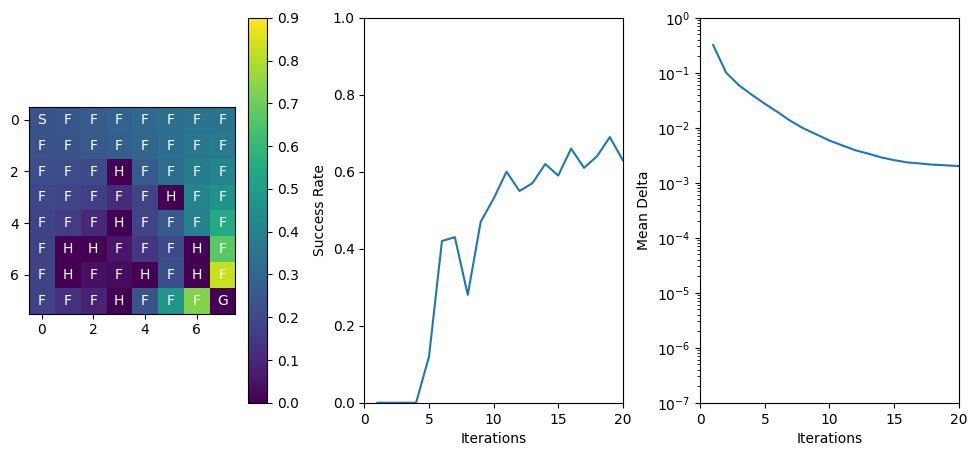

In [ ]:
def value_iteration(
    env: FrozenLakeEnv,
    gamma: float,
    n_iters: int,
    random_init: bool = True,
) -> plt.Figure:
    """Value Iteration algorithm

    :param env: a FrozenLakeEnv environment
    :param gamma: discount factor
    :param n_iter: number of loop iterations
    :param random_init: initialize value function randomly or as all zeros?
    :return: Figure containing final value function and learning curves
    """

    n_states = env.observation_space.n
    n_actions = env.action_space.n
    mdp = env.unwrapped.P
    rng = np.random.default_rng(seed=SEED)
    if random_init:
        value = rng.normal(loc=0, scale=0.5, size=(n_states,))
    else:
        value = np.zeros(shape=n_states)
    pi = np.zeros(shape=n_states, dtype=np.int64)  # contains the actual actions

    # setup plotting
    fig, (ax_value, ax_success, ax_change) = plt.subplots(1, 3, figsize=(12,5))
    fig.subplots_adjust(wspace=0.3)
    grid = (nrow, ncol) = (env.unwrapped.nrow, env.unwrapped.ncol)
    image_value = ax_value.imshow(value.reshape(grid), vmin=0.0, vmax=0.9)
    fig.colorbar(image_value)
    for i in range(nrow):
        for j in range(ncol):
            desc = env.unwrapped.desc[i, j].decode()
            ax_value.text(j, i, desc, ha="center", va="center", color="w")
    ax_success.set(xlabel="Iterations", ylabel="Success Rate")
    ax_success.set_xlim(0, n_iters)
    ax_success.set_ylim(0.0, 1.0)
    line_success, *_ = ax_success.plot([], [])
    ax_change.set(xlabel="Iterations", ylabel="Mean Delta")
    ax_change.set_xlim(0, n_iters)
    ax_change.set_ylim(1e-7, 1.0)
    ax_change.set_yscale("log")
    line_change, *_ = ax_change.plot([], [])

    env.reset(seed=int(rng.integers(2**32)))

    success_rates = []
    mean_delta_values = []
    for iter in range(0, n_iters):
        previous_value = np.copy(value)

        ## TODO ##
        for state in range(n_states):  # loop over all states
            qs = []  # list for q values in current state
            for action in range(n_actions):
                transition = mdp[state][action]
                q_s_a = sum(
                    transition_prob
                    * (reward + (not done) * gamma * previous_value[next_state])
                    for transition_prob, next_state, reward, done in transition
                )
                qs.append(q_s_a)

            # optimal action is the one with the highest q
            pi[state] = np.argmax(qs)
            # value of state is the q of the best action
            value[state] = np.max(qs)
        ## END ##

        # Evaluate policy success rate
        success_rate = measure_policy_success(env, pi, n_eval=100)
        success_rates.append(success_rate)

        mean_delta_value = np.abs(value - previous_value).mean()
        mean_delta_values.append(mean_delta_value)

        # update plots
        display.clear_output(wait=True)
        image_value.set_data(value.reshape(grid))
        line_success.set_xdata(np.arange(len(success_rates)) + 1)
        line_success.set_ydata(success_rates)
        line_change.set_xdata(np.arange(len(mean_delta_values)) + 1)
        line_change.set_ydata(mean_delta_values)
        display.display(fig)

    # clear duplicate plot
    display.clear_output(wait=True)

    return fig


# Run Value Iteration
fig = value_iteration(env, gamma=0.99, n_iters=20, random_init=True)
save_figure(fig, "value_iteration")


Here we initialize a value function randomly and then run $20$ iterations of value iteration.
How is this different from running $20$ iterations of policy iteration (the previous task) with `max_iters_policy_eval` set to $1$?
Which one converges faster?

Answer: Value iteration **simultaneously** computes the optimal policy and the next value function **in a single step**.
In contrast, policy iteration (with `max_iters_policy_eval=1`) first updates the value function using the **old** policy, and only then updates the policy.
The difference is highlighted by the first iteration of each algorithm, where policy iteration sets the value function equal to the mean Q over all actions (because the policy is initialized uniformly), whereas value iteration sets the value function equal to the Q of the best action in each state.

The heat map of the value function for policy iteration is noticably lighter (i.e. higher values) than the value function for value iteration.
Is there a reason why policy iteration converges to higher state values than value iteration, or can this discrepancy be resolved?

Answer: Value iteration just takes somewhat longer to converge.
Set `n_iters=200` and you will see that the heat maps become almost identical.
Since the optimal value function is unique, and both of these algorithms converge to the optimal value function (and optimal policy), they must converge to the same value function.

Play with the hyperparameters for this algorithm if you wish.

What happens if the value function is initialized uniformly to $0$ instead of randomly (set `random_init=False`)?
Why does convergence slow down?

Answer: There is actually nothing fancy going on here, it's sort of a quirk of value iteration and strongly depends on the scale of the Gaussian used to initialize the value function randomly.
If the value function is initialized from $\sim N(0, 0.5)$, there is a good chance that some states are initialized with a value near $0.5$, which is near the average value over all states of the optimal value function (in this case).
These states then propagate this higher value to all nearby states, such that most of the states quickly approach a value near $0.5$, which is the optimal value.
There are (on expectation) an equal number of states that are initialized to values near $-0.5$, which are very far from the optimal value, but these states do not propagate their values to neighboring states.
This is because the update function of value iteration only takes the best action (and therefore only the best neighboring states) into account.
If you want to test this, try changing `scale=0.5` to `scale=0.01`, and it behaves very similar to initializing with $0$.
In contrast, random initialization with `scale=2.0` also slows down convergence.

Be sure to set to the values back to their original values before generating the figures for submission!

## **TASK 3: Q-Learning**
In Policy Iteration and Value Iteration, we assume that we have knowledge about the problem's underlying dynamics (the dictionary of transitions) and the reward function.
This information is usually not available in practice.
Instead, we must solve the problem using only the trajectories we have already seen, and ensure we collect sufficient new trajectories through exploration.
One common and effective algorithm for solving such problems is Q-Learning.

The **pseudocode** look as follows:

---
- **Initialize** $Q_{(0)}(s, a)$ randomly for all $s$ and $a$

- **Repeat** for $i=1, 2, \dots$
    - sample an action $a$ using the exploration strategy and get the next state $s'$ and associated reward $r$

    \begin{align*}
        \delta &= r(s, a) + \overline{d} \gamma \underset{a'}{\max} Q_{(i-1)}(s', a') - Q_{(i-1)}(s, a) \\
        Q_{(i)}(s, a) &= Q_{(i-1)}(s, a) + \alpha \delta
    \end{align*}
    
    - If $s'$ is terminal: reset environment and sample new initial state $s'$
    - Set $ s \leftarrow s' $

- **Until convergence**
---

### Task 3.1 (4 Points)
Finally, you have to implement the core algorithm of **QLearning** (4 points), marked by `##TODO##`.
Just like in the pseudocode above, you should first compute the TD-Error $\delta$ and then update the Q function.

After you have finished implementing the corresponding functions, execute the code cell.
If implemented correctly, your algorithm should be able to solve the task with something between 60% and 80% success rate, although the variability is high.

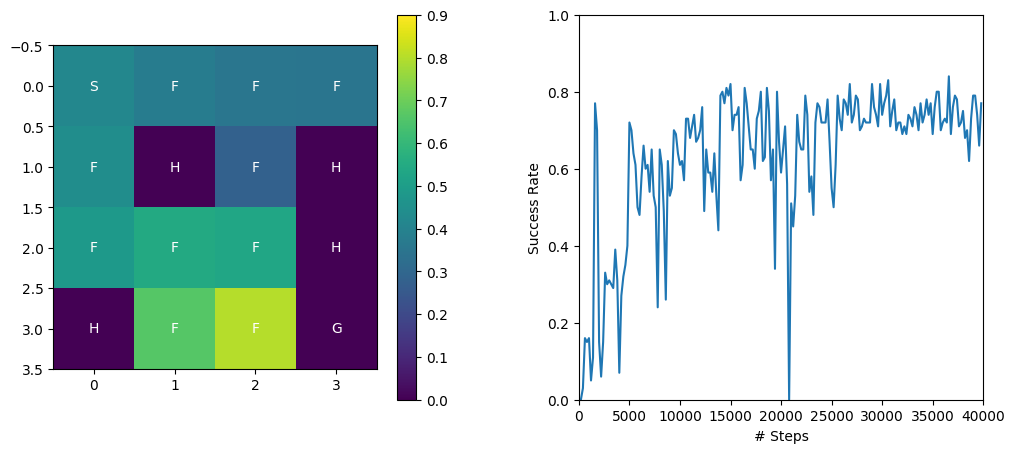

In [ ]:
def q_learning(
    env: FrozenLakeEnv,
    alpha_init: float,
    gamma: float,
    n_steps: int,
    t_decay: int | float,
    random_init: bool = True,
) -> plt.Figure:
    """Q-Learning algorithm

    :param env: a FrozenLakeEnv environment
    :param alpha: initial learning rate (decays over time)
    :param gamma: discount factor
    :param n_steps: total number of steps the agent takes in the environment
    :param t_decay: hyperparameter that controls the rate of exploration decay
    :param random_init: initialize Q function randomly or as all zeros?
    :return: Figure containing final value function and learning curve
    """
    eval_every = n_steps // 200
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    rng = np.random.default_rng(SEED)
    if random_init:
        q = rng.normal(loc=0, scale=0.5, size=(n_states, n_actions))
    else:
        q = np.zeros((n_states, n_actions))
    value = np.max(q, axis=1)

    # setup plotting
    fig, (ax_value, ax_success) = plt.subplots(1, 2, figsize=(12,5))
    fig.subplots_adjust(wspace=0.3)
    grid = (nrow, ncol) = (env.unwrapped.nrow, env.unwrapped.ncol)
    image_value = ax_value.imshow(value.reshape(grid), vmin=0.0, vmax=0.9)
    fig.colorbar(image_value)
    for i in range(nrow):
        for j in range(ncol):
            desc = env.unwrapped.desc[i, j].decode()
            ax_value.text(j, i, desc, ha="center", va="center", color="w")
    ax_success.set(xlabel="# Steps", ylabel="Success Rate")
    ax_success.set_xlim(0, n_steps)
    ax_success.set_ylim(0.0, 1.0)
    line_success, *_ = ax_success.plot([], [])

    state, info = env.reset(seed=int(rng.integers(2**32)))

    ts = []
    success_rates = []
    for t in range(n_steps):
        epsilon = max(0.01, 1 - t / t_decay)
        alpha = max(0.01, alpha_init * (1 - t / n_steps))

        ## TODO ##
        # select action using epsilon-greedy method
        if rng.random() < epsilon:
            # return a random action
            action: int = rng.integers(n_actions)
        else:
            # return the greedy action, i.e. the one with the highest q
            action: int = int(np.argmax(q[state]))
        ## END ##

        next_state, reward, terminated, truncated, info = env.step(action)

        ## TODO ##
        delta = reward - q[state, action] + (not terminated) * gamma * np.max(q[next_state])
        q[state, action] = q[state, action] + alpha * delta
        ## END ##

        if terminated or truncated:
            state, info = env.reset()
        else:
            state = next_state

        # evaluate policy success rate
        if t % eval_every == 0:
            value = np.max(q, axis=1)
            pi = np.argmax(q, axis=1)

            ts.append(t)
            success_rate = measure_policy_success(env, pi, n_eval=100)
            success_rates.append(success_rate)

            # update plots
            display.clear_output(wait=True)
            image_value.set_data(value.reshape(grid))
            line_success.set_xdata(ts)
            line_success.set_ydata(success_rates)
            display.display(fig)

    # clear duplicate plot
    display.clear_output(wait=True)

    return fig

# Run QLearning
small_env: FrozenLakeEnv = gym.make("FrozenLake-v1", map_name="4x4", render_mode="rgb_array")
fig = q_learning(
    small_env,
    alpha_init=0.2,  # initial learning rate (decays over time)
    gamma=0.99,  # discount factor
    n_steps=40000,  # total number of steps the agent takes in the environment
    t_decay=20000,  # controls the rate of exploration decay
    random_init=False,  # initialize Q function randomly or with 0?
)
save_figure(fig, "q_learning")


Why do you think that the success rate of Q-learning varies more during learning than it does with policy iteration or value iteration?

Answer: Q-learning does not have access to the environment dynamics, making the learning problem much harder.
As a result, there is no guarantee of monotonic improvement.
In contrast, policy and value iteration are guaranteed to improve on each iteration (or at least not be worse), and the variance in the measured success rate is only due to the stochasticity in the environment.

When we measure success, we set the policy to be just the argmax over all actions in each state.
Why does this approach hurt exploration, especially during the initial stages of training?

Answer: If we initialize the Q-function to all $0$ instead of randomly and then set the policy to be the argmax action for each state, the argmax just returns the first element.
Instead of taking a random action when there is a tie, the policy will simply take the "first" action in the action space, which in this case is to go left.
This hurts exploration, although it's not such a large effect because we also use epsilon-greedy exploration.

Play with the hyperparameters for this algorithm if you wish.
Can you find better hyperparameters?
Change the random seed as well, to see if your hyperparameters are still good for different random conditions.

What happens if the Q function is initialized randomly instead of uniformly to $0$?
Why does training become much slower?

Answer: Learning becomes slower because the algorithm first has to "unlearn" any bad actions that were randomly initialized with a high value.
However, this depends on the type and scale of random initialization.
If the scale is reduced from $0.5$ to e.g. $0.1$, learning can be even faster than zero initialization, because it counteracts the argmax/exploration issue mentioned above.
Keep in mind that this is only the case in tabular RL!
If a neural net is initialized with all zeroes, the gradients are uniform and it cannot learn.
In deep reinforcement learning, initialization is always random.

Be sure to set to the values back to their original values before generating the figures for submission!

### Task 3.2 (3 Points)

For the previous task, we used the 4x4 version of the FrozenLake environment because Q-Learning requires many samples and converges quite slowly.
Run the code cell below to try your Q-Learning implementation on the full 8x8 version of the environment.

The algorithm should reach a success rate around $60%$, but sometimes the success rate drops sharply during training.
In my experimentation, the algorithm doesn't learn with `SEED = 6` (leave all other hyperparameters at their defaults).
In addition, there are regions of the environment (e.g. the bottom left) where the Q function still differs from the optimal Q function computed in questions 1 and 2, with no sign that they are improving.
Given this, it is reasonable to wonder if this algorithm will ever converge to the optimal policy.


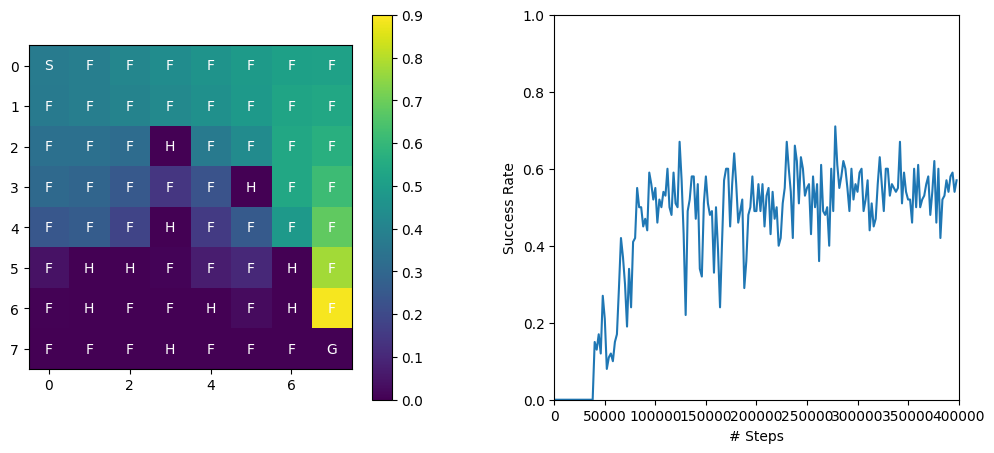

In [ ]:
# Run QLearning on the 8x8 environment
SEED = 1
_ = q_learning(env, gamma=0.99, alpha_init=0.2, n_steps=400000, t_decay=200000, random_init=False)
